In [1]:
!pip install pillow

  Using cached https://files.pythonhosted.org/packages/85/5e/e91792f198bbc5a0d7d3055ad552bc4062942d27eaf75c3e2783cf64eae5/Pillow-5.4.1-cp36-cp36m-manylinux1_x86_64.whl
You are using pip version 9.0.3, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
MODEL_NAME = 'mask_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [3]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [5]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                     image_width):
  """
      Transforms the box masks back to full image masks.
  """
  
  def transform_boxes_relative_to_boxes(boxes, reference_boxes):
    boxes = tf.reshape(boxes, [-1, 2, 2])
    min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
    max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
    transformed_boxes = (boxes - min_corner) / (max_corner - min_corner)
    return tf.reshape(transformed_boxes, [-1, 4])

  box_masks = tf.expand_dims(box_masks, axis=3)
  num_boxes = tf.shape(box_masks)[0]
  unit_boxes = tf.concat(
      [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
  reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)
  image_masks = tf.image.crop_and_resize(image=box_masks,
                                         boxes=reverse_boxes,
                                         box_ind=tf.range(num_boxes),
                                         crop_size=[image_height, image_width],
                                         extrapolation_value=0.0)
  return tf.squeeze(image_masks, axis=3)

In [6]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [25]:
from PIL import ImageDraw
from matplotlib import gridspec
from matplotlib import pyplot as plt

image_path = 'data/test4.jpg'
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
im_width, im_height = image.size
numDetections = output_dict['num_detections']
boxes = output_dict['detection_boxes']
classes = output_dict['detection_classes']
scores = output_dict['detection_scores']
masks = output_dict['detection_masks']


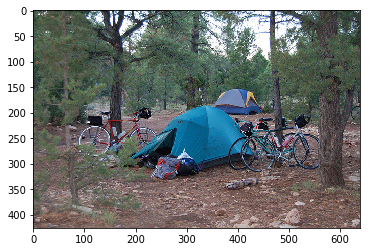

In [9]:
plt.imshow(image)

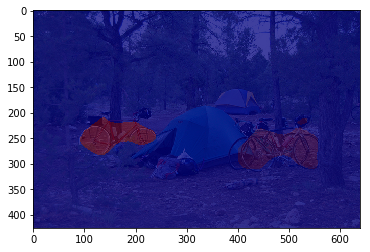

In [26]:
masks = output_dict['detection_masks']
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

plt.imshow(image)
for i in range(numDetections):
    if classes[i] == 2 and scores[i] >= 0.95:
        mask = masks[i]        
        plt.imshow(mask, cmap = 'jet', alpha=0.5)